# Finding treatment effect on cancer using time periods before and after treatment
The steps in the analysis so far are:

1. Self-controlled measurement of cancer incidence in patients before versus after exposure to treatment 
2. Create an estimate of expected number of cancers in the exposed period, based on the unexposed period
    - Control for the difference in age in the exposed vs unexposed periods
    - Control for the causal effect of cancer on drug Rx
3. Estimate the Relative Risk of cancer under treatment


## 1. Self-controlled cancer incidence
We choose a window after treatment called `effect_window` and a window before treatment called `comparison_window`.  First, for each drug (or drug combination), select only those patients with this amount of time observed before and after the drug is administered.  Any patients without this amount of time observed are removed

For each of these patients, define two time periods and count number of people  with onset of cancer in each:
- **exposed**: the total time that drug was administered, plus `effect_window` time after the last administration, if the patient has this amount of time observed. 
- **unexposed**: the same length of time before drug was administered, or if not available, a length of time defined by `comparison_window`

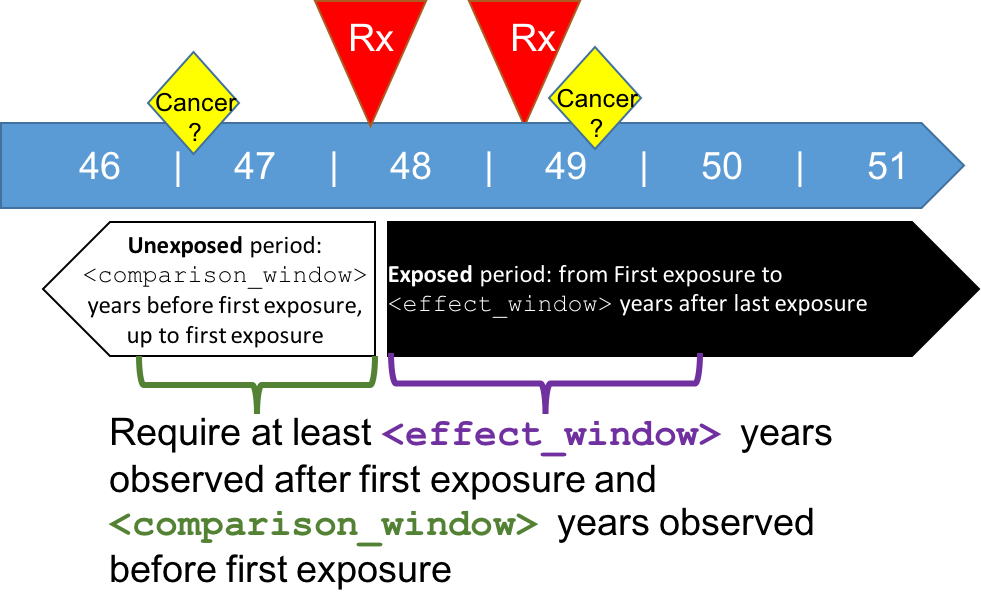

In [19]:
Image(filename='png/timeline.png',width=600)

## 2. Estimate expected number of cancers
We want to use the Unexposed period cancers to estimate the expected number of cancers in the Exposed period, after which we can assess treatment effect (step 3).  In order to estimate expected number of cancers in the exposed period, there are (at least..) two factors we need to control for:  the difference in age (year?) in the exposed vs unexposed, and the causality of cancer on drug-prescribing.

### 2.1 Controlling for age
In the previous analysis, I did not control for age but only accounted for the difference in the number of weeks observed in Unexposed versus Exposed patients.  I calculated expected cancers in patients exposed (*e*) to drug *d* ($E_{d,e}$) based on the rate of cancer in these patients in the unexposed time (*u*):  
$$ E_{d,e} = { {\sum_{drug-takers} I(cancer in Unexposed Weeks)  } \over \sum_{drug-takers} \# unexposedWeeks } \times  { \sum_{drug-takers} \# ExposedWeeks } $$

To adjust for age I used a poisson model for age effects, with a "weeks exposed" offset.  I fit a separate model for each drug *d*, for the **unexposed** time *u*: 
$$ cancer_{d,u} \sim weeks_{d,u} * exp[{ \beta_1*age_{d,u} + \beta_2*age_{d,u}^2 }]$$

Then, use this unexposed model to predict number of cancers in the **exposed** time.  

While it's not clear that cancer is polynomial in age, using the polynomial has advantages over using age bins:
- Some medium frequent drugs are not observed in patients of all ages in the "unexposed" category, so we would not be able to model predicted cancer in the "exposed"
- People are slightly older "after" than "before" taking the drug, but they might not be in a different age bin in the  two time periods, depending on how fine the bins are.

Below, each point is a drug, and I compare the RR (empirical bayes 90% CI) for polynomial (y-axis, poly) versus the simple model (simp) without an age effect. The left plot is the upper end of the CI (used for assessing the protective effect), and on the right is the lower end of the CI (lower bound on predisposing effect). You can see especially for drugs that have a high .05 CI, the value is lower with the age adjustment, reflecting the importance of accounting for age. 


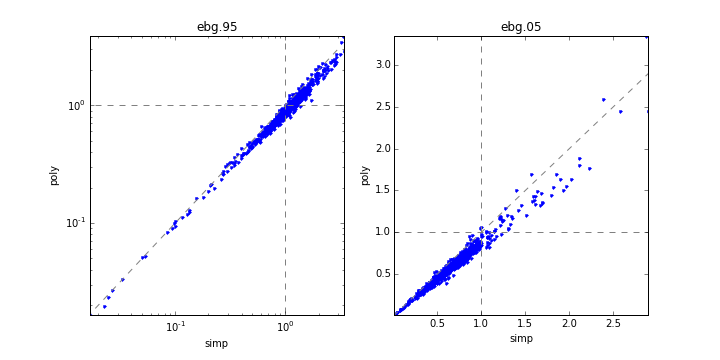

In [18]:

Image(filename='png/poly_vs_simp.png',width=800)

However, this model is probably noisy.  It might be better to average models created from bootstrap samples of the unexposed population. Below, for each of 100 samples of the population before exposure to Cefnidir, I fit a quadratic model as above, and predicted the number of cancers under exposure to Cefnidir. The dashed line contains the single-model fit.  The bootstraps predict +/- 150 cancers, around 5% variance.  This variance will depend on the drug-- some are less commonly prescribed, or different incidence of cancer. 

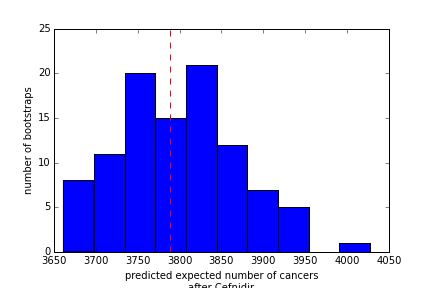

In [20]:
Image(filename='png/boot.png',width=400)

## 2.2  Causality of cancer -> Drug
The second adjustment we need to make to estimate expected cancers in the exposed period is to adjust for causality of cancer:

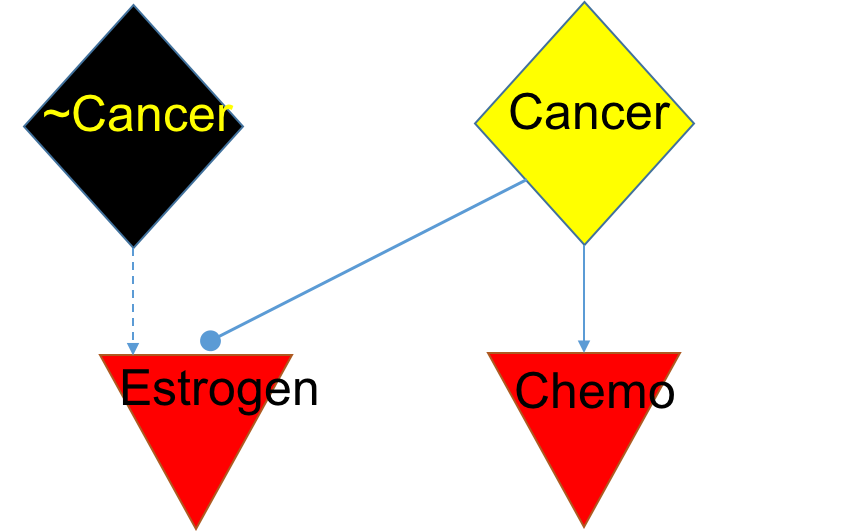

In [15]:
Image(filename='png/causality.png',width=400)

Breast Cancer causes less prescription of some drugs (estrogens).  Thus fewer cancer cases will be present in the time period before estrogen Rx: there are probably many people with cancer who would have been prescribed estrogen, but cancer caused them to not be prescribed estrogen.

Conversely, cancer causes prescription of some drugs (chemo). This leads to a high "expected" rate of cancer after prescription.

In order to account for this, we can consider a cancer-centric (rather than drug-centric) view:


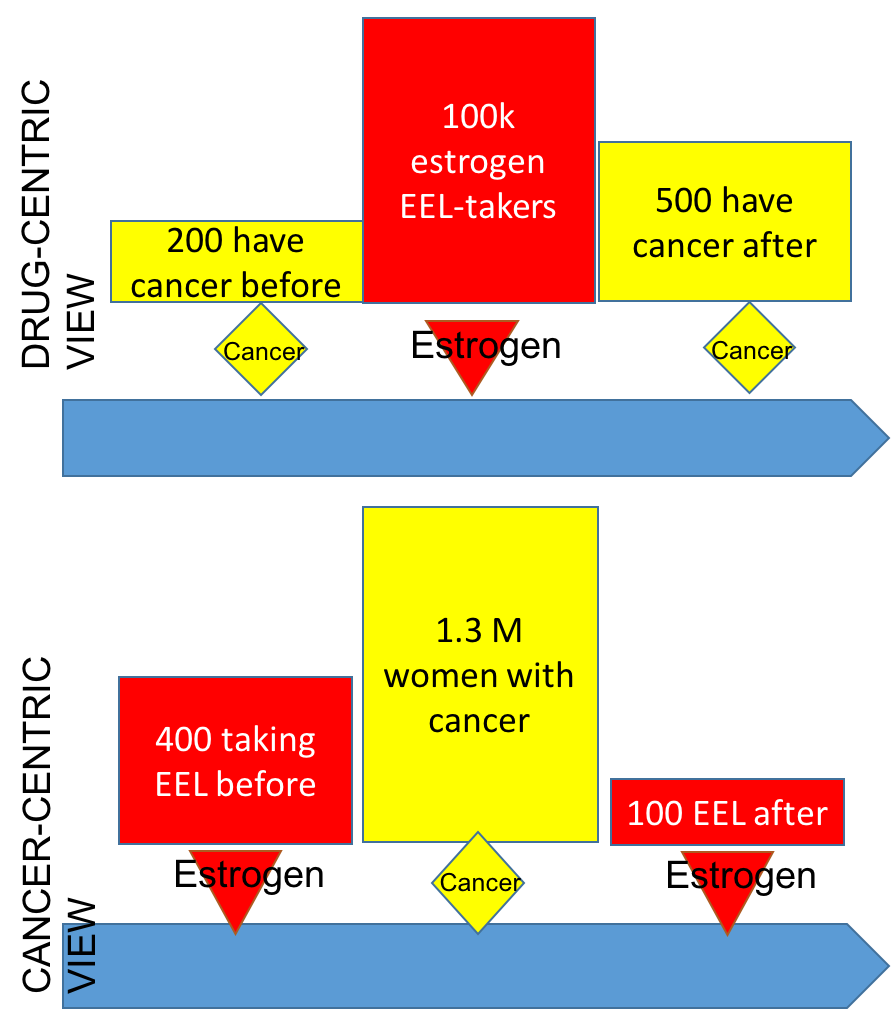

In [14]:
Image(filename='png/eel.png',width=400)


I looked at *first prescription* of a drug occuring in the two years before versus the two years after cancer, for all patients with both periods observed.  Incidence of drug should be corrected for year and age but I have not done it yet.  

Then, we can use the same statistics as in <a href="https://github.com/RDMelamed/writeups/blob/master/apr4_RR_CI.ipynb">april 4 writeup about Gamma-Poisson shrinker</a>:
For a given drug $d$, using observed incidence of prescription after dancer $A_d$ and prescription before cancer $B_d$, we want to calculate **Relative Prescribing Rate = $RRx_d$** before versus after cancer:  $ RRx_d = \lambda_d = { \mu \over A_d } $:
- $ B_d \sim Poisson(\mu_d) = Poisson( \lambda_d * A_d ) $
- $ \lambda_d \sim \Gamma(\alpha, \beta) $ as a prior distribution

Then, using the Gamma-Poisson mixture, if you integrate out lambda, $ B_d \sim NegativeBinomial(\alpha, { A_d \over {\beta + A_d }}) $. Using empirical bayes, you get $\alpha, \beta $, and then you can get the posterior distribution:  $$ RRx_d = \lambda_d \sim \Gamma(\alpha + B_d, \beta + A_d) $$

From this posterior Gamma distribution, number of prescriptions before and after cancer, and the .05 and .95 quantiles of the distribution of 1/RRx (after/before) are shown for the drugs with the most extreme values:

In [10]:
### highest prescription after cancer
pd.read_table('png/before_after_cancer.txt',sep='\t',index_col=0).iloc[:5,:]

,beforeCancer,afterCancer,ebg.05,ebg.95
gel__multi_ingredient,6,487,58.907116,68.359321
rivaroxaban,0,105,53.484015,73.545374
anastrozole,384,14768,37.777933,38.814509
exemestane,71,2664,35.514606,37.851131
letrozole,221,7067,31.124939,32.366938


In [12]:
### most reduced prescription after cancer
pd.read_table('png/before_after_cancerLCI.txt',sep='\t',index_col=0)

,beforeCancer,afterCancer,ebg.05,ebg.95
valdecoxib,567,0,0.000695,0.008618
rofecoxib,409,0,0.000962,0.011933
guaifenesin_potassium_guaiacolsulfonate,82,2,0.017002,0.094295
dm_hydrobrom_gg_k_guai,41,2,0.033329,0.184847
guaifenesin,98,12,0.085658,0.208510
estradiol;estradiol_norgestimate,33,2,0.041014,0.227469
conjugated_estrogens_synthetic_a,110,16,0.104863,0.229334
ethinyl_estradiol_norelgestromin,91,14,0.109101,0.250440
conjugated_estrogens_medroxyprogesterone_ace,641,155,0.213266,0.277373
telithromycin,954,242,0.229131,0.282885


Particularly, you can see coxibs, and other discontinued drugs appear to have a lower rate after cancer, which is purely due to the year of prescription.  Other drugs have changed rates probably due to cancer.  If the disparity in drugs is only caused by cancer (rather than the drugs causing a change in cancer), then we use the following relationship:

$$ RRx = {Rx\ before\ Cancer \over Rx\ after\ cancer} = { Cancer\ after\ Rx \over Cancer\ before\ Rx }$$
or
$$ 1/RRx = {  Rx\ after\ cancer \over Rx\ before\ Cancer} = {Cancer\ before\ Rx \over  Cancer\ after\ Rx }$$
Where the right-most term represents the expected ratio of cancers in the Exposed period as compared to the unexposed period. 

## 3. Estimating relative risk of cancer under treatment
Thus, let:
- **$K_d$** = the expected number of cancers in the exposed period, for the set of drug-takers with no cancer in unexposed period, adjusting (see 2.1) only for age, as well as difference in the length of the periods observed.  So:  $ K_d = {\sum_{i} weeksExposed_{i} * exp[{ \beta_1*ageExposed_{i} + \beta_2*ageExposed_i^2 }] }$
- **$L_d$** = corresponding number of cancers expected to occur after Rx, adjusting for Rx incidence caused by cancer, using the relationship in 2.2.   This should follow the Gamma-Poisson mixture as before.  But now, the Gamma comes from section 2.2, rather than another empirical bayes:
    $$ L_d \sim  Poisson(RRx_d*K_d)*\Gamma(\alpha + B_d, \beta + A_d) $$
Integrating out the distribution of RRx gives us a distribution of expected number of cancers after adjusting  for age and for cancer caused by drug:
    $$ L_d \sim NegBin(\alpha + B_d, { K_d \over { \beta + A_d + K_d } }) $$
 
Now we want to integrate over that to estimate the Treatment Effect of a drug on cancer, or Relative Risk **$M_d$**:
- **$M_d$** = the Relative Risk we want to estimate for drug *d*:  $ M_d = { exposed\ risk \over unexposed\ risk } $
- **$n_d$** = observed number of cancers after treatment, in people who did not get cancer before treatment.  Similar to before we can model this as the result of a Poisson process using 
    $$ N_d \sim Poisson( n_d | expectedCancer * exposureRisk ) = Poisson(n_d | L_d * M_d) $$ 
    
$L_d$ and $M_d$ should be independent, so the joint distribution could be: 
    $$ P(N_d, L_d, M_d) \sim Poisson(N_d | L_d * M_d)* NegBin(L_d | \alpha + B_d,  { K_d \over {\beta + A_d + K_d}}) * \Gamma(M_d | \gamma, \delta) $$

### 3.1 Distribution of $M_d$
Given a fixed prior $\Gamma(\lambda_0, \delta_0)$, for a given $L_d$, we can get the distribution of $ M_d \sim \Gamma( n_d + \lambda_0, L_d + \delta_0 ) $

Possibly we can do a sampling approach to estimate $M_d$:
- Sample $K_d$ using bootstraps to estimate the linear model for cancer incidence
- Sample $L_d$ using the negative binomial with $K_d$ given above
- Then, for each $L_d$ get the 90% CI of $M_d$.  This will give us a distribution of 90% CI's

It might be nicer to figure out the conditional distribution: if there's a faster way to calculate $M_d$, this might help since 100k drug combinations must be calculated:

$$ M_d \sim {P(N_d, L_d, M_d) \over {P(N_d, L_d)}} $$



In [13]:
from IPython.display import Image